In [1]:
import time
start_time=time.time()

In [2]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import lmfit


604

Define a series of model structure functions. First the basic version that is derived from a model of the autocorrelation:

In [3]:
def bfunc00(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = 1.0 / (1.0 + (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

Then a version with a seeing cut-off at small scales:

In [4]:
def bfunc01(r, r0, sig2, m, s0):
    "Structure function with added seeing (scale `s0`)"
    seeing = (np.tanh((r / (2.0 * s0)**2)))**2
    return seeing * bfunc00(r, r0, sig2, m)

Load the data for NGC 604

In [5]:
data = json.load(open("SFdata//604.json"))

sns.set_color_codes()


pixscale = 0.26 # arcsec
pixscale *= 4.09              # parsec
r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]
B_w = np.array(data["Weighted B(r)"])
sig2_w = data["Weighted sigma^2"]
s0 = 4.09/2.355                    # parsec




In [6]:
r

array([  1.0634    ,   1.50209242,   2.12176195,   2.99706841,
         4.23347165,   5.97993765,   8.44688645,  11.93154424,
        16.85375421,  23.80656059,  33.62766064,  47.50033319,
        67.09600401,  94.77562476, 133.87412829])

In [7]:
B

array([  1.9057852 ,   3.90697386,   7.22286646,  13.48128552,
        23.47866655,  36.72422086,  52.04679308,  65.95774045,
        75.41742209,  93.83361035, 123.03824318, 140.89454558,
       120.49165553,  87.17814977,  59.48587133])

Plot the observed structure function together with the model.  I have adjusted the "by eye" values to get a better fit.  I have also considered the seeing width as a free parameter and adjusted that too. 

Since we have defined a function for the model structure function, we should use it for the plots instead of typing in the equation again by hand.

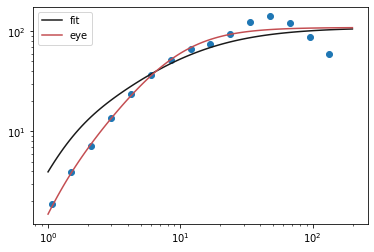

In [8]:
plt.scatter(r,B)

s0 = 0.5
lo = 10.56
n = 1.15
xx = np.logspace(0.0, 2.3, 100)
yy_fit = bfunc01(xx, lo, sig2, n, s0)
plt.loglog(xx, yy_fit, color='k', linestyle='-', label='fit')

s0 = 0.5 - 0.05
lo=9.09 - 0.2
n=1.7 + 0.1
yy_eye = bfunc01(xx, lo, sig2, n, s0)

plt.loglog(xx, yy_eye, color='r', linestyle='-', label='eye')

plt.legend()

Now, try and use `lmfit`.  Again, we want to be using the function we have already defined.  Also, we should use a consistent set of names for the parameters.

I am going to try and follow the example of the [Gaussian model from the documentation](https://lmfit.github.io/lmfit-py/model.html) since this seems simpler than the metho.d that Javier was using.  For instance, the parameter names are deduced automatically from the model function, and we don't have to provide the residual function ourselves

In [9]:
model01 = lmfit.Model(bfunc01)
model01.param_names

['r0', 'sig2', 'm', 's0']

In [10]:
model01.independent_vars

['r']

That looks good!  But note that it is treating `sig2` as a free parameter also.  We may want to change that, but for now we will let it be.

In [11]:
result = model01.fit(B, r=r, r0=9.09, sig2=sig2, m=1.7, s0=0.5)

In [12]:
print(result.fit_report())

[[Model]]
    Model(bfunc01)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 15
    # variables        = 4
    chi-square         = 4805.09968
    reduced chi-square = 436.827244
    Akaike info crit   = 94.5407430
    Bayesian info crit = 97.3729438
[[Variables]]
    r0:    8.33386120 +/- 2.01207375 (24.14%) (init = 9.09)
    sig2:  52.5444990 +/- 5.42492004 (10.32%) (init = 54.62046)
    m:     2.15969036 +/- 0.95469933 (44.21%) (init = 1.7)
    s0:    0.15311270 +/- 101150.636 (66062865.68%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2) =  0.590
    C(sig2, m)  = -0.536
    C(r0, m)    = -0.314
    C(m, s0)    =  0.107


So that is very encouraging: the fitted values of `r0`, `sig0`, and `m` are not totally unreasonable.  Although we allowed `sig0` to vary, the fitted value is very close to the original.  

The confidence limits on `r0` and `sig0` are quite small, but the limits on `m` are very broad: $2.16 \pm 0.95$, which is not surprising.  The value of `s0` is basically unconstrained, which is again unsurprising.  This is *not* a problem because `s0` is a nuisance parameter (of no interest to us).  If it turns out to have no effect on the fits, then so much the better!

The reduced chi-square is very large, but this is not maningful since we have not yet provided any information about the data uncertainties.

Modify style of plots.  Make the labels larger.  Also, set to dark background since I am using dark mode in jupyterlab (Javier may wish to comment that out).

In [13]:
plt.style.use([
    "dark_background", 
    "seaborn-poster",
])

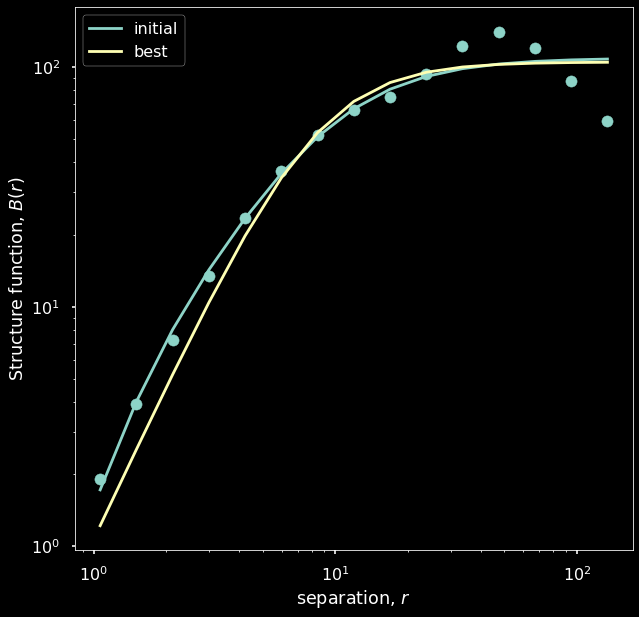

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(r, B)
ax.plot(r, result.init_fit, label="initial")
ax.plot(r, result.best_fit, label="best")
ax.legend()
ax.set(
    xlabel="separation, $r$",
    ylabel="Structure function, $B(r)$",
    xscale="log",
    yscale="log",
);

So we see that the "best" fit does not look like an improvement on the initial guess at all!  This is because the fit is using uniform weighting, which means that the large values of $B$ dominate the fit.  But it will never be able to fit the points at large $r$ ...

We can see this by plotting the residuals.  In fact, there is a convenience function to do this plot, although it uses a linear scale:

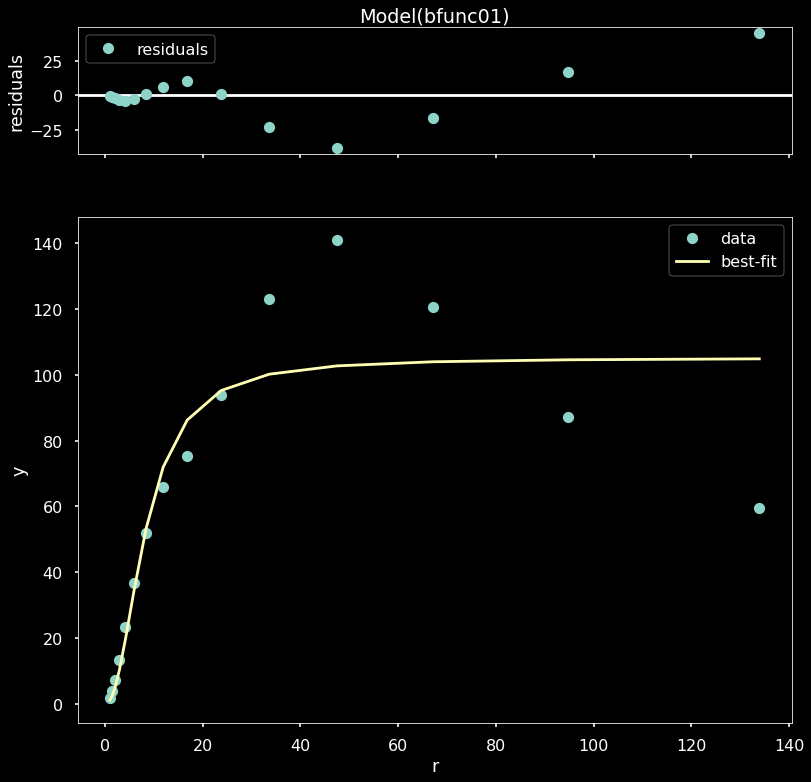

In [15]:
result.plot();

So the residuals are very small for r < 20, but then get very large at larger scales.  I had suggested fitting in log space, but that would be very fiddly.  We can achieve the same result by weighting the data points.  

If we set the weight to be inversely proportional to B, then this should reduce the importance of the large scales.  The weight should be $1/\varepsilon$ where $\varepsilon$ is the uncertainty in each data point. 

As a first approximation, set the relative uncertainty to be 10% for most of the points. But then set it to 40% for the last 5 points, since we cannot hope to fit the largest scales:

In [16]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[-5:] /= 4.0

Now, recalculate the fit using these weights:

In [17]:
result2 = model01.fit(
    B, 
    weights=weights,
    r=r, r0=9.09, sig2=sig2, m=1.7, s0=0.5
)

Now I have figured out how to set logarithmic scales for the automatic plot.  We use "symlog" for the residuals because the values can be negative. 

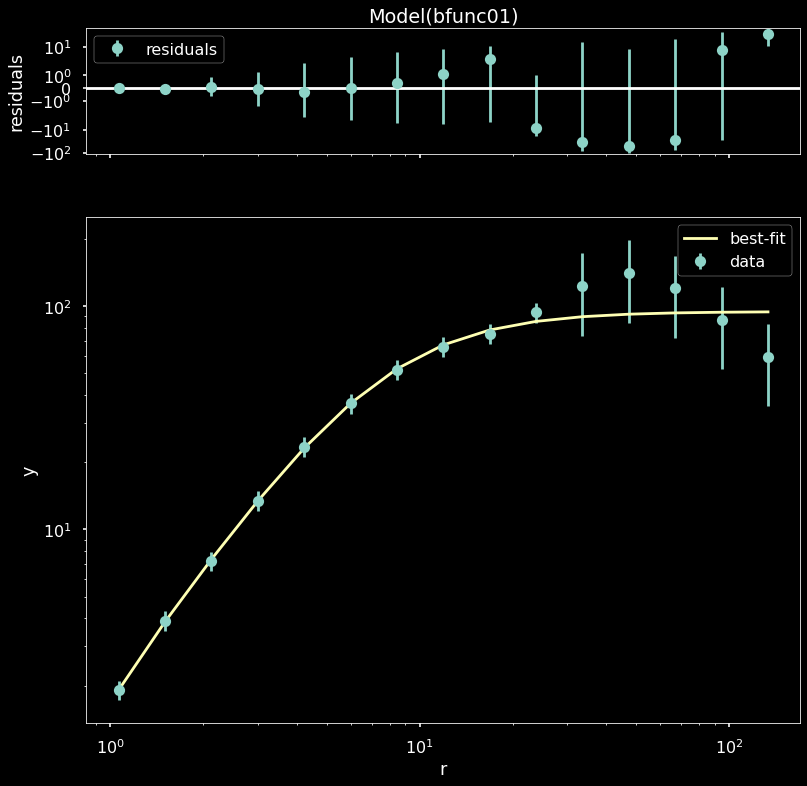

In [18]:
fig, _ = result2.plot()
fig.axes[0].set(
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale="log",
    yscale="log",
);

This looks much better. The fit is well within the 10% error bars for the small scales, out to r = 20 or so. 

We will also plot it the previous way, so we can compare with the initial guess.

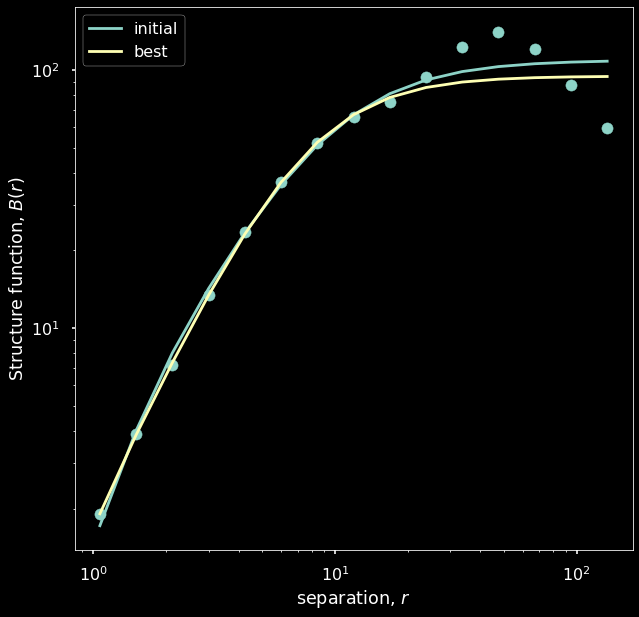

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(r, B)
ax.plot(r, result2.init_fit, label="initial")
ax.plot(r, result2.best_fit, label="best")
ax.legend()
ax.set(
    xlabel="separation, $r$",
    ylabel="Structure function, $B(r)$",
    xscale="log",
    yscale="log",
);

The "best" fit now looks like a real improvement over the original.  Now look at the fit report:

In [20]:
print(result2.fit_report())

[[Model]]
    Model(bfunc01)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 15
    # variables        = 4
    chi-square         = 4.73762968
    reduced chi-square = 0.43069361
    Akaike info crit   = -9.28769886
    Bayesian info crit = -6.45549805
[[Variables]]
    r0:    7.55728728 +/- 0.60617333 (8.02%) (init = 9.09)
    sig2:  47.3380086 +/- 2.91556058 (6.16%) (init = 54.62046)
    m:     1.94730869 +/- 0.09452427 (4.85%) (init = 1.7)
    s0:    0.35769624 +/- 0.08604817 (24.06%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2) =  0.906
    C(r0, m)    = -0.890
    C(m, s0)    = -0.778
    C(sig2, m)  = -0.706
    C(r0, s0)   =  0.552
    C(sig2, s0) =  0.439


The reduced chi-square is now less than 1, which means it is an acceptable fit. 

The uncertainties on the parameters are much tighter now.  Even the seeing width is constrained within 25%. 

There are quite a lot of strong correlations between the parameters, which we ought to investigate.

But first, we will try and calculate the 1-dimensional confidence limits for each parameter:

In [21]:
result2.conf_interval()
print(result2.ci_report())

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0  :  -1.67765  -1.09955  -0.56997   7.55729  +0.68940  +1.68605  +3.51629
 sig2:  -9.29076  -5.82424  -2.86844  47.33801  +3.20174  +7.42508 +14.20627
 m   :  -0.41581  -0.22695  -0.10069   1.94731  +0.08949  +0.17065  +0.27790
 s0  :      -inf      -inf      -inf   0.35770  +0.06482  +0.12213  +0.19822


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/lmfit/confidence.py:334: UserWarning: rel_change=0.0 < 1e-05 at iteration 4 and prob(s0=0.013503569411239535) = 0.41069400165340014 < max(sigmas).
  warn(errmsg)


So this gives a table that shows the 3-sigma, 2-sigma, 1-sigma confidence bounds around the best value.  For instance, for the slope `m`, the 3-sigma interval is 1.95 -0.42 +0.28. 

Now I will plot the 2D confidence ellipse for selected pairs of parameters, based on examples [in the documentation](https://lmfit.github.io/lmfit-py/confidence.html). This takes about 10 seconds to run on my laptop:

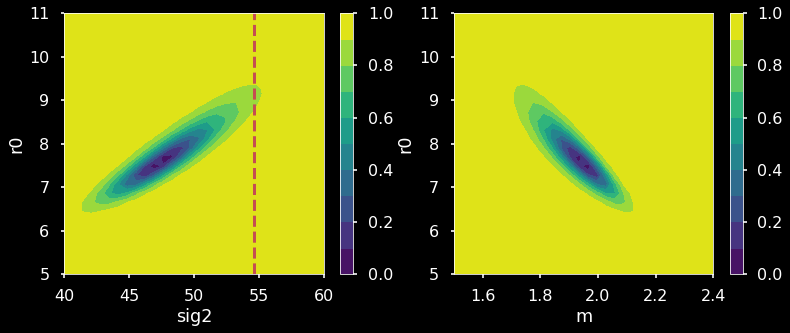

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'sig2', 'r0', 30, 30,
    limits=[[40, 60], [5, 11]],
)
ctp = axes[0].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[0])
axes[0].axvline(result2.init_params["sig2"].value, color="r", lw=3, ls="dashed")
axes[0].set_xlabel('sig2')
axes[0].set_ylabel('r0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'm', 'r0', 30, 30,
    limits=[[1.5, 2.4], [5, 11]],
)
ctp = axes[1].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[1])
axes[1].set_xlabel('m')
axes[1].set_ylabel('r0');


This shows contours of reduced chi-squared.  Any model with chi-squared < 1 is "acceptable", which means anything except the yellow regions. 

I have marked the "true" value of `sig2` with a red dashed line.  This does intersect the chi-squared < 1 region. but only just!

So. if we fixed sig2 at this value, then we would get r0 = 9 and m = 1.8 with even smaller uncertainties. 

In [23]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 17.688969135284424 seconds ---
